## MonReader
The goal of this project is to create a model which can take in an image or a series of images and determine if the page if being flipped. We have labelled data that is split into training and test data already. We further split the training data into training and validation data for a neural network. 

We will need to input the images into the neural network. This requires breaking the images into their matrix format with pixel location, and RGB colour scheme. After doing this we can experiment with the amount of dense layers to achieve a high F1 score using a CNN. First let's input the data and look. It is best to use an online platform in order to access a GPU/TPU to reduce training time. We will use google Colab.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Mount the drive so we can access the data

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

training_data_path = "gdrive/MyDrive/Colab Notebooks/data/training"
testing_data_path = "gdrive/MyDrive/Colab Notebooks/data/testing"

Mounted at /content/gdrive


In [4]:
training_data_path_flipped = os.path.join(training_data_path, "flip")
training_data_path_not_flipped = os.path.join(training_data_path, "notflip")

testing_data_path_flipped = os.path.join(testing_data_path, "flip")
testing_data_path_not_flipped = os.path.join(testing_data_path, "notflip")

## Data Preprocessing
We have first imported an ImagedataGenerator class in which we can apply transformations on the images. We can specify a validation split, lets use 20 percent of our training data as a validation set in order to monitor for overfitting. We can also reduce the image size to reduce training time/number of overall inputs. This is a trade off, a larger image will give us better results, but larger training time. We can adjust the parameters to offer a balance of these two features. We also set the batch size to 32.



In [5]:
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(training_data_path,
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=123,
                                                        image_size=(320, 180),
                                                        batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(training_data_path,
                                                      validation_split=0.2,
                                                      subset="validation",
                                                      seed=123,
                                                      image_size=(320, 180),
                                                      batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['flip', 'notflip']


Lets look at a visual of some of the images to get a better idea of what patterns our neural network will attempt to find.

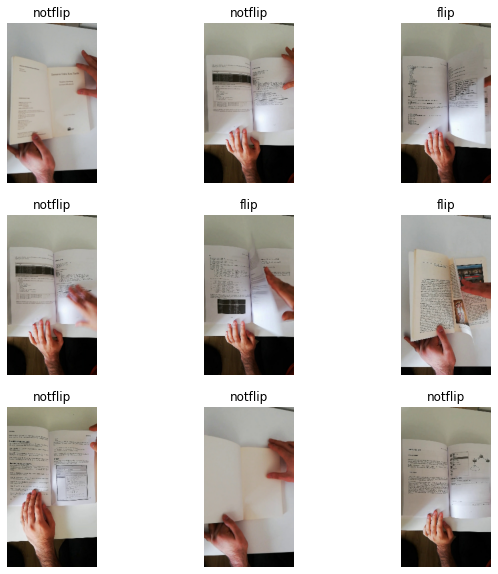

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We can see some differences, the position of the page, the blurriness of the photo, how many pages can be seen
The position of the hand to name some patterns. 

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 320, 180, 3)
(32,)


## Building the model
Lets try to build a CNN. We can start with the backbone of our neural network. We can use a pre built model called EfficientNetB1. This is a CNN that is part of a seven model stack from B0-B7. B0 is lightweight while B7 increases power and complexity. Our model does not need to be overly complex, and a lower tiered model will perform well, let's use B1.

In [10]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input
 
backbone = EfficientNetB1(include_top = False,
                          input_shape = (320, 180, 3),
                          pooling = 'avg')

27033600/27018416 [==============================] - 0s 0us/step


Let's finish putting our model together. We will use a Sequential model and add out backbone layer we described above. Next we will add a Dense layer, a dense layer is a simple layer of neurons that recieves inputs from all neurons of a previous layer, this is incredibly useful for a CNN. Next we will add a LeakyRelu activation function. We will also add a BatchNormalization Layer, this standardizes inputs form the activation function. We will finally add another dense layer with the number of classes we will predict which is 2. Lastly we will add a softmax output layer, Softmax is used for predictive classification as an output layer.

In [11]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Softmax
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
n_classes = 2
dense_count = 256
 
model = Sequential()
model.add(backbone)
 
model.add(Dense(dense_count))
model.add(LeakyReLU())
model.add(BatchNormalization())
 
model.add(Dense(n_classes))
model.add(Softmax())

Let's compile our model using an Adam optimizer and set a learning rate of 0.001, and track the loss as sparse categorical crossentropy.

In [12]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

Let's take a final look at our model.

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
 softmax (Softmax)           (None, 2)                 0         
                                                        

Let's create a directory for logs, and train our model!

In [14]:
logdir = os.path.join("data", 'logs')
os.makedirs(logdir, exist_ok=True)

tbCallBack = keras.callbacks.TensorBoard(log_dir = logdir,
                                         histogram_freq = 0,
                                         write_graph = False,
                                         write_images = False)

first_stage_n = 15

history = model.fit(train_ds,
                    steps_per_epoch = 60,
                    epochs = first_stage_n,
                    validation_data = val_ds,
                    validation_steps = 15,
                    callbacks=[tbCallBack],
                    use_multiprocessing = True,
                    workers = 16
                   )


Epoch 1/15
60/60 [==============================] - 201s 3s/step - loss: 0.2689 - sparse_categorical_accuracy: 0.9242 - val_loss: 1.8658 - val_sparse_categorical_accuracy: 0.7803
Epoch 2/15
60/60 [==============================] - 90s 1s/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.1905 - val_sparse_categorical_accuracy: 0.9582
Epoch 3/15
60/60 [==============================] - 90s 1s/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0161 - val_sparse_categorical_accuracy: 0.9958
Epoch 4/15
60/60 [==============================] - 90s 1s/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9854
Epoch 5/15
60/60 [==============================] - 90s 1s/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0055 - val_sparse_categorical_accuracy: 0.9979
Epoch 6/15
60/60 [==============================] - 90s 1s/step - loss: 0.0201 - sparse_categorical_accuracy:

As shown above we hit a very good accuracy of 99.9% within fifteen epochs. We also have our validation data performing at 100%, showing that our model is not overfit. This is quite a successful result. Let's take a look at our loss, plotting our loss and our accuracy.

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


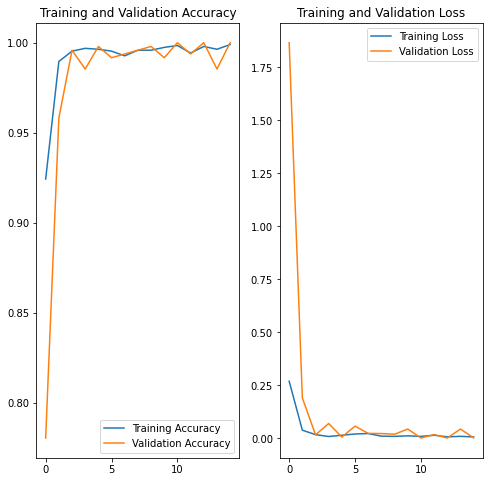

In [15]:
print(history.history.keys())
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(first_stage_n)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing our model
As a last step let's predict our model against our testing data to see how it performs and return our performance metrics!

In [16]:
test_dir = 'gdrive/MyDrive/Colab Notebooks/data/testing'
testing_data_path_flip = "gdrive/MyDrive/Colab Notebooks/data/testing/flip"
testing_data_path_notflip = "gdrive/MyDrive/Colab Notebooks/data/testing/notflip"

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')

In [18]:
##create an array full of out images form the flip and not flip directory.
from keras.preprocessing import image
images = []
for img in os.listdir(testing_data_path_flip):
    img = os.path.join(testing_data_path_flip, img)
    img = image.load_img(img, target_size=(320, 180))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

for img in os.listdir(testing_data_path_notflip):
    img = os.path.join(testing_data_path_notflip, img)
    img = image.load_img(img, target_size=(320, 180))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

let's stack our images and predict the images

In [19]:
images = np.vstack(images)
classes = model.predict(images)

In [23]:
print(classes)

[[9.9999630e-01 3.7247312e-06]
 [9.9993730e-01 6.2693696e-05]
 [9.9971563e-01 2.8435388e-04]
 ...
 [2.7995874e-08 1.0000000e+00]
 [6.5349731e-08 9.9999988e-01]
 [2.6414209e-08 1.0000000e+00]]


Now we can convert those results from the softmax layer to classes

In [35]:
y_pred = []
for prediction in classes:
  if prediction[0] > prediction[1]:
    n=0
  else:
    n=1
  y_pred.append(n)
y_pred = np.array(y_pred)


Now lets get the classes from our test data

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_ds = test_datagen.flow_from_directory(
        test_dir,
        target_size=(320, 180),
        batch_size=batch_size,
        class_mode='binary')
true_classes = test_ds.classes

Found 597 images belonging to 2 classes.


Finally let's compare our results and see how we did!

              precision    recall  f1-score   support

        flip       1.00      0.99      0.99       290
     notflip       0.99      1.00      1.00       307

    accuracy                           0.99       597
   macro avg       1.00      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597

[[288   2]
 [  1 306]]


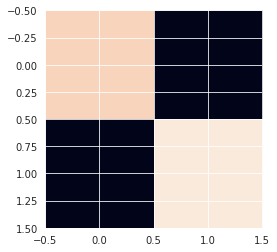

In [38]:
class_labels = list(test_ds.class_indices.keys())
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

cm=confusion_matrix(true_classes,y_pred)
print(cm)

plt.imshow(cm)

## Conclusion
Our model achieved an fscore of 99% for flipped images, and 100% for notflip images. This is a great result and our model is performing at a very high rate.

To summarize, we first created generators for our validation and training inputs from the training dataset, created our model from a prebuilt model, and added some extra layers to improve performance. We trained our model to high accuracy for both training and validation data. We then tested our model against the test data to acheive the results above.